# Amplitude Source Location (ASL)

## 1. Introduction

### 1.1 Review

In the previous tutorial, we estimated Reduced Displacement by assuming a source location, e.g. the summit of a volcano. But it would be better if we locate volcano-seismic signals, and then compute Reduced Displacement. Most volcano-seismic signals cannot be located using traditional differential travel-time techniques, because they lack identifiable phases (sources are quasi-continuous, so phases are arriving all the time). So what else can we do?

### 1.2 Motivation
In summer 1996, I was fortunate enough as a graduate student to be asked to assist the British Geological Survey in its monitoring of the Soufriere Hills Volcano, Montserrat. As part of "Team Seismic" at the Montserrat Volcano Observatory, our job was to provide 24-7 monitoring of the lava dome eruption, which had been continuous since October 1995. Crucially, this involved two-way radio communications with others working on the slopes of the volcano, and warning them of seismicity, especially pyroclastic flows [Add video here from Lauren's Journeys program]. 

I had the idea that we could use the RSAM data to locate seismicity continuously, on a map on a monitor in the Ops Room. I created a proof-of-concept, using the 60-s RSAM data (the 2.56-s RSAM data wasn't captured) to locate tremor. And then later applied it to triggered event files for rockfalls and pyroclastic flows. We will replicate that here using Displacement Seismic Amplitude Measurement data, which is like RSAM that has been instrument-corrected. For simplicity - and speed which was important for a real-time system - we ignore the vertical dimension (topography and station elevations ignored), and assume an isotropic, homogeneous half-space.

First, we will run a simulation, to demonstrate that our location technique works, showing that we can simulate a set of source locations, and then recover them with our location technique. Then we will compute locations for real DSAM data, and then for a known pyroclastic flow signal. For the latter, we will use a 5-s moving window, which we shift by 1-s through the whole length of the signal.

### 1.3 Caveats

I call the approach above "naive" ASL, because for simplicity (and speed, for real-time application) it ignores the vertical dimension, and assumes a homogeneous, isotropic half space (1-layer). It also considers the seismic source to be a point source, and assumes only one event is occurring at a time. In reality, pyroclastic flows cause multiple seismic sources per unit time, over an extended area, and this evolves with time as the flow moves downhill. Moreover, there can be numerous pyroclastic flows travelling down different flanks of the volcano at the same time, such as in a major dome collapse which may be comprised of dozens of pyroclastic flows that reach the coast. This ASL technique can only estimate an average location of all seismicity recorded in each time window.


### 1.4 ASL Notebook Migration Guide

This notebook has been updated to use the refactored `flovopy.asl` package structure.  
Below are the common import changes (old → new):

| Old import | New import(s) |
|---|---|
| `from flovopy.analysis.asl import ASL` | `from flovopy.asl.asl import ASL` |
| `from flovopy.analysis.asl import AmpCorr, AmpCorrParams` | `from flovopy.asl.ampcorr import AmpCorr, AmpCorrParams` |
| `from flovopy.analysis.asl import make_grid, Grid` | `from flovopy.asl.grid import make_grid, Grid` |
| `from flovopy.analysis.asl import compute_or_load_distances` | `from flovopy.asl.distances import compute_or_load_distances` |
| `from flovopy.analysis.asl import topo_map` | `from flovopy.asl.map import topo_map` |
| `from flovopy.analysis.asl import StdOverMeanMisfit` | `from flovopy.asl.misfit import StdOverMeanMisfit` |
| `from flovopy.analysis.asl import apply_station_gains_to_stream` | `from flovopy.asl.station_corrections import apply_station_gains_to_stream` |
| *(legacy station gains by year JSON helpers)* | Use interval-based gains: `from flovopy.asl.station_corrections import apply_interval_station_gains, load_station_gains_df` |

> Tip: If you previously used wildcard imports (`from flovopy.analysis.asl import *`), the updated cells below switch to explicit imports for clarity and stability.

### 1.5 Setup

We need to import the following, and set some paths, to set things up.


In [29]:
# Quick environment & import smoke-check
import os, sys, obspy, time
import numpy as np
import pandas as pd
from pathlib import Path
# Core ASL + utilities
# --- Core ASL ---
from flovopy.asl.asl import ASL, asl_sausage
from flovopy.asl.grid import Grid, make_grid
from flovopy.asl.distances import compute_or_load_distances, distances_signature
from flovopy.asl.ampcorr import AmpCorr, AmpCorrParams
from flovopy.asl.misfit import StdOverMeanMisfit, R2DistanceMisfit, LinearizedDecayMisfit
from flovopy.asl.map import topo_map

# --- Diagnostics / comparisons ---
from flovopy.asl.diagnostics import extract_asl_diagnostics, compare_asl_sources

# --- Simulation helpers ---
from flovopy.asl.simulate import simulate_SAM, plot_SAM, synthetic_source_from_grid

# --- Station gains (interval-aware) ---
from flovopy.asl.station_corrections import (
    load_station_gains_df,
    save_station_gains_df,
    apply_interval_station_gains,
    gains_series_to_interval_df,
)

print("Python:", sys.version.split()[0])
print("NumPy:", np.__version__)
print("Pandas:", pd.__version__)
print("ObsPy:", obspy.__version__)
print("[OK] Imports succeeded.")

os.chdir('/Users/glennthompson/Dropbox/BRIEFCASE/SSADenver/test_mess2024')
SDS_DIR = Path.cwd().joinpath('data','continuous','SDS')
SAM_DIR = Path.cwd().joinpath('data','continuous','SAM')
DEM_DIR = Path.cwd().joinpath('data','DEMs')
RESPONSE_DIR = Path.cwd().joinpath('data','responses')

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6, 6)
plt.rcParams["figure.dpi"] = 150  # more pixels per inch


Python: 3.12.11
NumPy: 2.3.3
Pandas: 2.2.3
ObsPy: 1.4.2
[OK] Imports succeeded.


## 2. Synthetic testing

### 2.1 Map of Montserrat stations
We generate a map of seismic stations with a vertical-component sensor, operational (though not necessarily working properly) on July 12, 2003. This 13-station network provides good azimuthal coverage.

grdimage [ERROR]: Unrecognized keyword MAP_FRAME_AXES.
grdimage [ERROR]: Unrecognized keyword MAP_FRAME_AXES.
/Users/glennthompson/Developer/flovopy/flovopy/asl/map.py:87: FutureWarning: The 'interval' parameter has been deprecated since v0.12.0 and will be removed in v0.16.0. Please use 'levels' instead.
  Create a topographic basemap using PyGMT with optional station overlays.
grdcontour [ERROR]: Unrecognized keyword MAP_FRAME_AXES.
grdcontour [ERROR]: Unrecognized keyword MAP_FRAME_AXES.
colorbar [ERROR]: Unrecognized keyword FONT_ANNOT_PRIMARY.
colorbar [ERROR]: Unrecognized keyword FONT_ANNOT_SECONDARY.
colorbar [ERROR]: Unrecognized keyword FONT_HEADING.
colorbar [ERROR]: Unrecognized keyword FONT_LABEL.
colorbar [ERROR]: Unrecognized keyword FONT_LOGO.
colorbar [ERROR]: Unrecognized keyword FONT_SUBTITLE.
colorbar [ERROR]: Unrecognized keyword FONT_TAG.
colorbar [ERROR]: Unrecognized keyword FONT_TITLE.
colorbar [ERROR]: Unrecognized keyword FORMAT_GEO_MAP.
colorbar [ERROR]: Unr

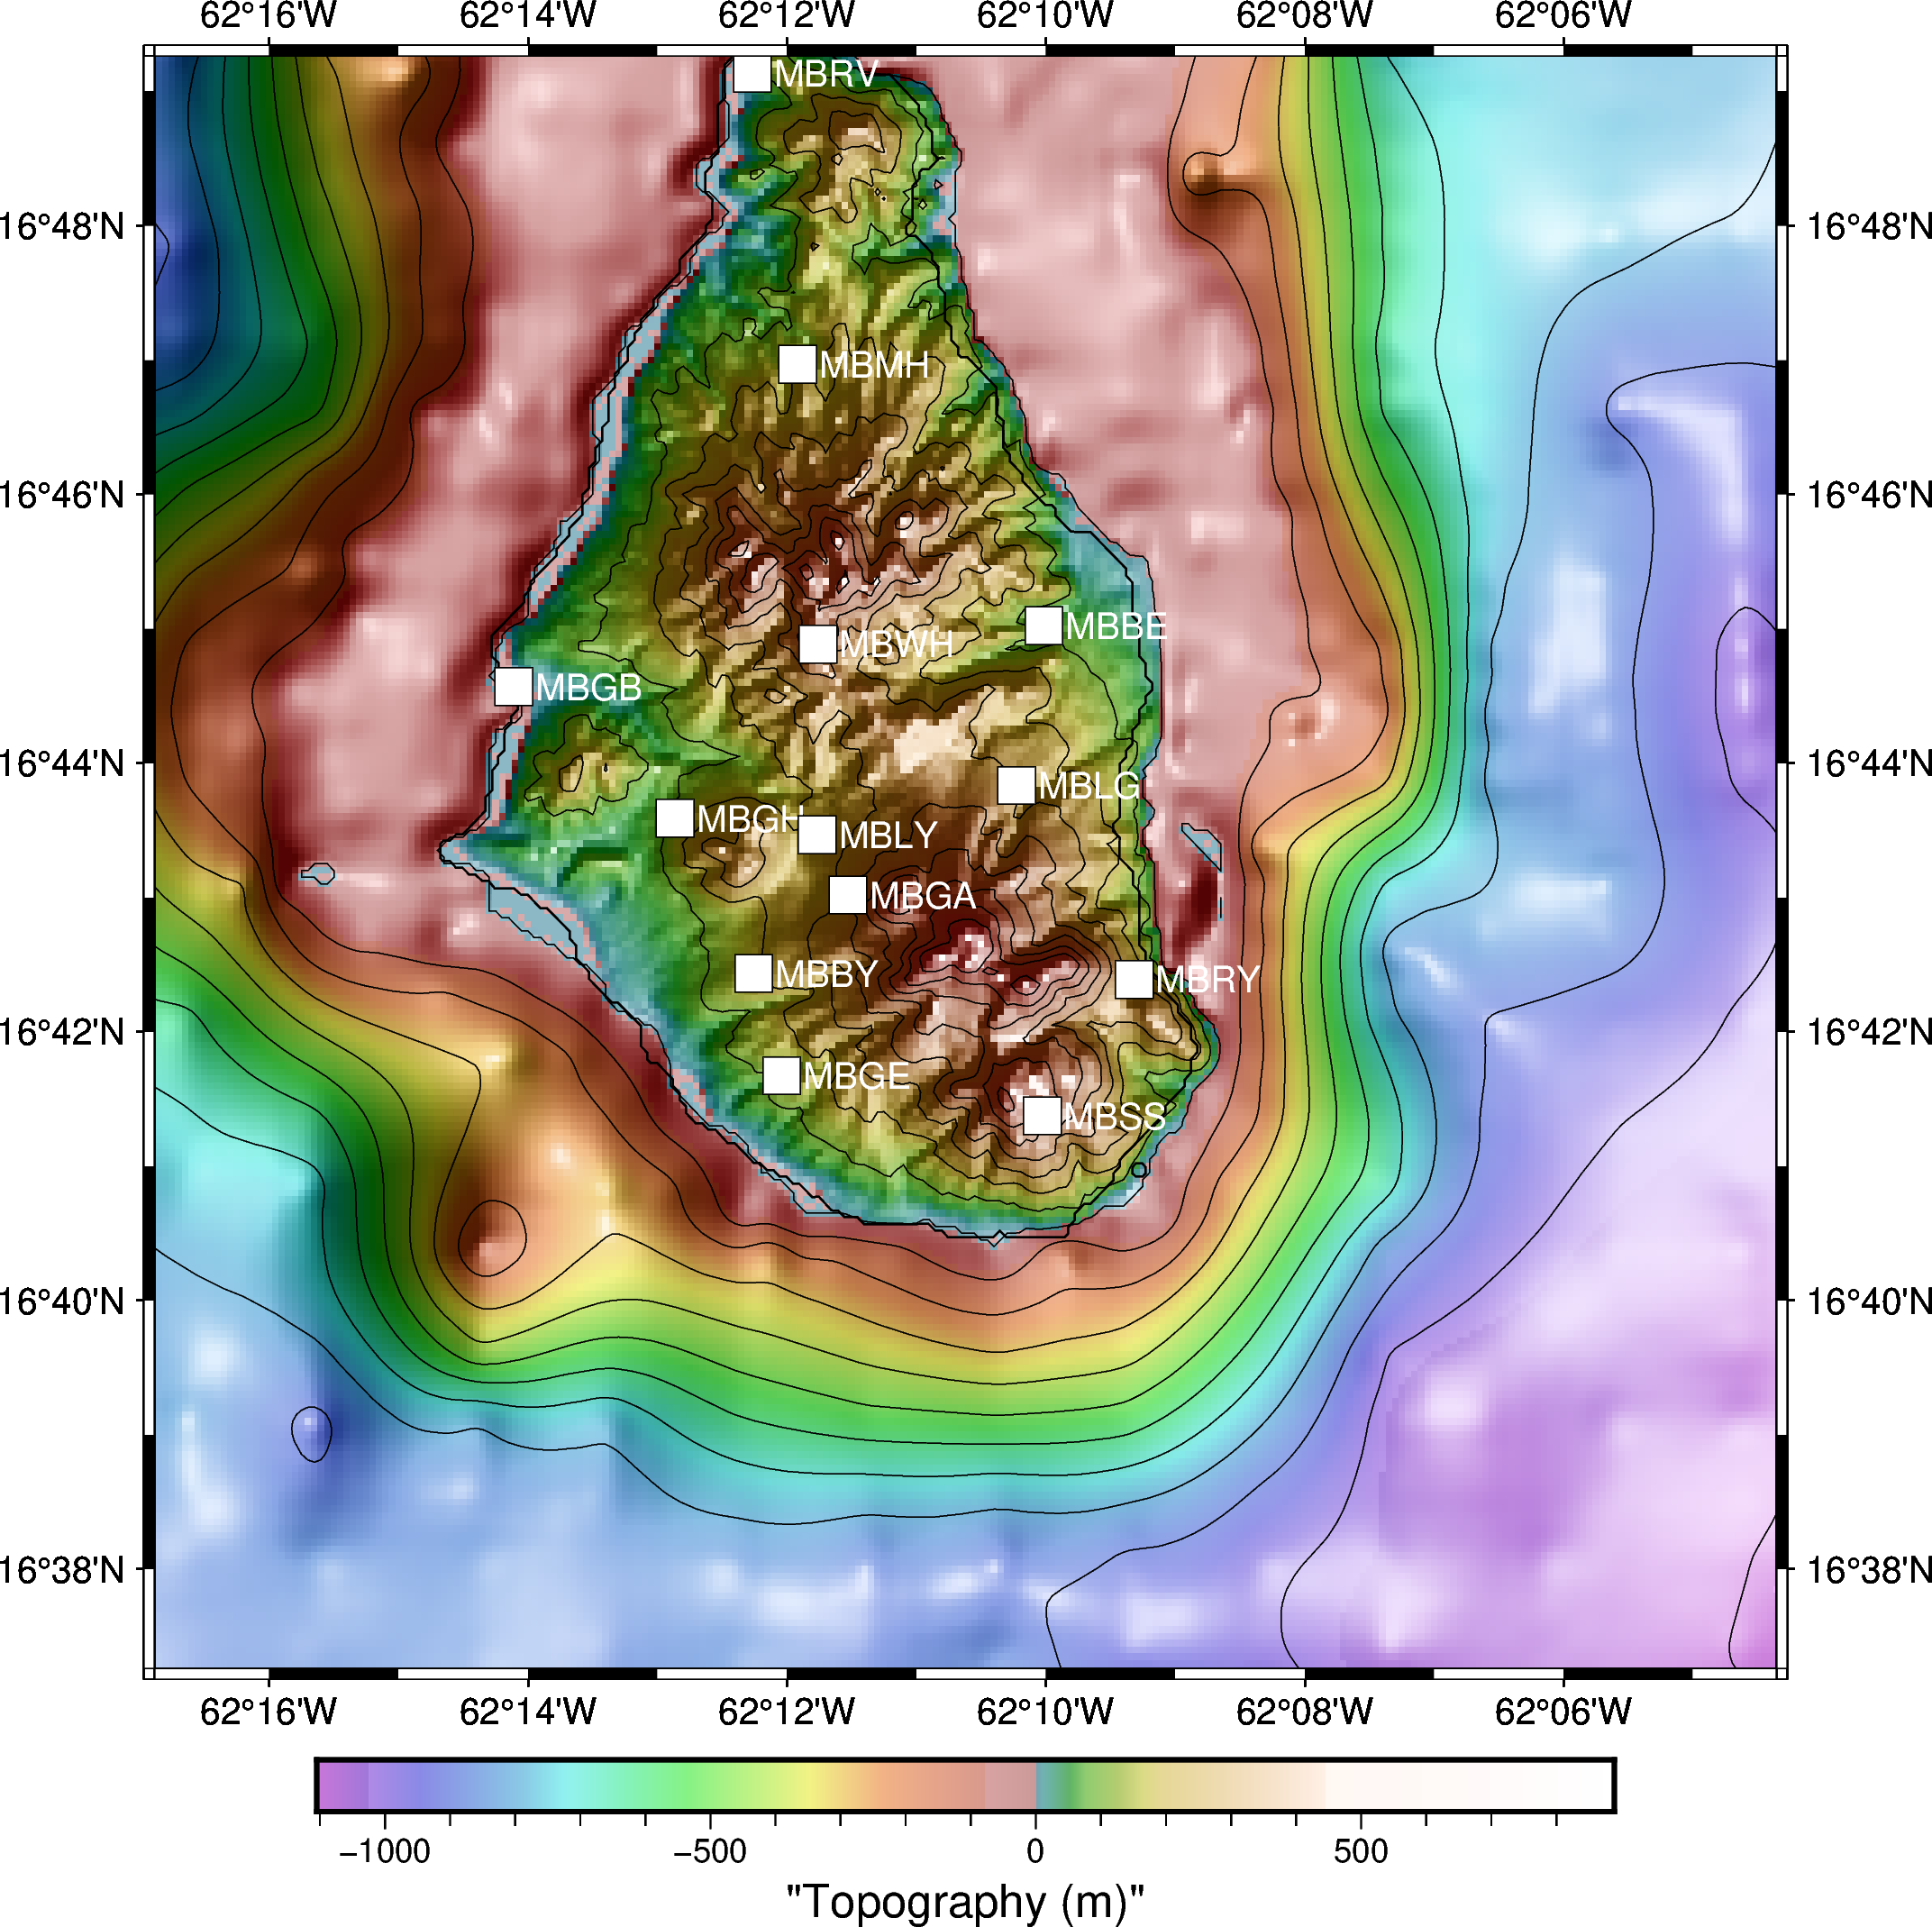

In [32]:
invMVO = obspy.read_inventory(os.path.join(RESPONSE_DIR,'MV.xml'), format='stationxml')
startt = obspy.UTCDateTime(2003,7,12,23,0,0)
endt = obspy.UTCDateTime(2003,7,13,4,0,0)
invMVO = invMVO.select(starttime=startt, endtime=endt)
invMVO = invMVO.select(channel='*Z')
topo_map(inv=invMVO, show=True, add_labels=True, resolution='03s', DEM_DIR=DEM_DIR);

### 2.2 Define a grid of source locations and reduced displacement at those nodes

In [ ]:
# params
sampling_interval = 1.0  # seconds, to simulate moving window

# grid params
node_spacing_m = 400
nlat = 8   # 11
nlon = 8   # 11
centerlat =  16.711
centerlon =  -62.177

gridobj = Grid(centerlat, centerlon, nlat, nlon, node_spacing_m)
topo_map_args = {'inv':invMVO, 'DEM_DIR':DEM_DIR, 'add_labels':True, 'zoom_level':2}
gridobj.plot(scale=2, symbol='c', topo_map_kwargs=topo_map_args)

synthetic_source = synthetic_source_from_grid(
    gridobj,
    sampling_interval=sampling_interval,
    DR_cm2=100.0,
    t0=obspy.UTCDateTime(0),
    order="C",
)

surfaceWaveSpeed_kms = 1.5
peakf = 8.0
Q = 23

synthVSAMobj = simulate_SAM(
    invMVO,
    synthetic_source,
    units='m/s',
    surfaceWaves=True,
    wavespeed_kms=surfaceWaveSpeed_kms,
    peakf=peakf,
    Q=Q,
    noise_level_percent=0.0,
    verbose=True,
)
synthVSAMobj.plot(metrics="mean")

In [ ]:
print(synthVSAMobj.get_seed_ids()  )
plot_SAM(synthVSAMobj, gridobj, K=3, metric='mean', DEM_DIR=DEM_DIR, inv=invMVO)

### 2.3 Plot synthetic source locations, and DR time series (all equal=100 ${cm}^2$)

In [ ]:
window_seconds = 1
aslobj = ASL(synthVSAMobj, 'mean', gridobj, window_seconds)
aslobj.source = synthetic_source
aslobj.plot(zoom_level=2, threshold_DR=1.0, scale=0.4)

### 2.4 Run slow location algorithm on synthetic source and plot resulting locations and DR time series

In [ ]:

# 1) Distances (no cache)
aslobj.compute_grid_distances(inventory=invMVO, stream=None)

# 2) Amplitude corrections (no cache)
aslobj.compute_amplitude_corrections(
    surface_waves=True,
    wavespeed_kms=surfaceWaveSpeed_kms,
    Q=Q,
    peakf=peakf,
    dtype="float32",
)

# 3) Locate & time
t0 = time.time()
aslobj.locate(verbose=True)
t1 = time.time()
print(f"[TIMER] Location algorithm took {t1 - t0:.3f} s")

# 4) Plot
aslobj.plot(zoom_level=2, scale=0.4, threshold_DR=0.0)

### 2.5 Run fast location algorithm on synthetic source and plot resulting locations and DR time series

In [ ]:
import copy
aslobj2 = copy.deepcopy(aslobj)
aslobj2.source = None
time1 = time.time()
aslobj2.fast_locate(misfit_backend=StdOverMeanMisfit())
time2 = time.time()
print(f'Vectorized location algorithm took {time2-time1} s')
aslobj2.plot(zoom_level=2, scale=0.4, threshold_DR=0.0)

# Compare results. Any differences?
from flovopy.asl.diagnostics import compare_asl_sources, plot_asl_source_comparison

# stats
report = compare_asl_sources(aslobj, aslobj2)
print(report)  # mean/max km divergence, DR deltas, etc.

# visuals
plot_asl_source_comparison(aslobj, aslobj2, title="locate vs fast locate (StdOverMean)")

In [ ]:
aslobj3 = copy.deepcopy(aslobj)
aslobj3.source = None
time1 = time.time()
# pure correlation (most aggressive)
aslobj3.fast_locate(misfit_backend=R2DistanceMisfit(use_log=True, square=True, alpha=1.0))
time2 = time.time()
aslobj3.print_source()
print(f'Vectorized location algorithm took {time2-time1} s')
aslobj3.plot(zoom_level=2, scale=0.4, threshold_DR=0.0)
print(compare_asl_sources(aslobj2, aslobj3))

# stats
report = compare_asl_sources(aslobj2, aslobj3)
print(report)  # mean/max km divergence, DR deltas, etc.

# visuals
plot_asl_source_comparison(aslobj2, aslobj3, title="StdOverMean vs pure R2Distance")


In [ ]:
# blended (often more stable in practice)
aslobj4 = copy.deepcopy(aslobj)
aslobj4.source = None
time1 = time.time()
aslobj4.fast_locate(misfit_backend=R2DistanceMisfit(use_log=True, square=True, alpha=0.5))
aslobj4.print_source()
time2 = time.time()
print(f'Vectorized location algorithm took {time2-time1} s')
aslobj4.plot(zoom_level=2, scale=0.4, threshold_DR=0.0)
print(compare_asl_sources(aslobj3, aslobj4))

# stats
report = compare_asl_sources(aslobj3, aslobj4)
print(report)  # mean/max km divergence, DR deltas, etc.

# visuals
plot_asl_source_comparison(aslobj3, aslobj4, title="pure R2Distance alpha=1.0, vs alpha 0.5")

In [ ]:
# blended (often more stable in practice)
aslobj5 = copy.deepcopy(aslobj)
aslobj5.source = None

backend = LinearizedDecayMisfit(f_hz=8.0, v_kms=1.5, alpha=1.0)  # pure Watson-style

time1 = time.time()
aslobj5.fast_locate(misfit_backend=backend, spatial_smooth_sigma=0.0, temporal_smooth_win=0)
time2 = time.time()
print(f'Vectorized location algorithm took {time2-time1} s')
aslobj5.plot(zoom_level=2, scale=0.4, threshold_DR=0.0)


# stats
report = compare_asl_sources(aslobj4, aslobj5)
print(report)  # mean/max km divergence, DR deltas, etc.

# visuals
plot_asl_source_comparison(aslobj4, aslobj5, title="R2Distance alpha=0.5, vs Watson")

### 2.6 Try to estimate decay power law exponent (N), and Q in exponential attenuation term.
In this case we know they should be N=0.5 (surface waves), and Q=23, since we synthesized the data used in this example with those values.


In [ ]:
print(aslobj.estimate_decay_params(use_reduced=False, verbose=True))
print(aslobj2.estimate_decay_params(use_reduced=False, verbose=True))
print(aslobj3.estimate_decay_params(use_reduced=False, verbose=True))
print(aslobj4.estimate_decay_params(use_reduced=False, verbose=True))
print(aslobj5.estimate_decay_params(use_reduced=False, verbose=True))
# params["N"], params["Q"] are your estimates

In [ ]:
def debug_station_mask(asl, backend, *, t_idx=None, target_time=None, j_global=None):
    """
    Inspect which stations are used by a misfit backend at a given time/node.

    Parameters
    ----------
    asl : ASL
    backend : Misfit backend instance
    t_idx : int, optional
        Time index into the metric stream. Must be in [0, ntime-1].
    target_time : obspy.UTCDateTime, optional
        If provided, we pick the closest index to this time. Ignored if t_idx is given.
    j_global : int, optional
        Global node index to inspect (required). If using refine masks, this will be
        mapped to the backend's local index.
    """
    assert j_global is not None, "Please provide j_global (global node index)."

    # --- stream → data ---
    st = asl.metric2stream()
    seed_ids = [tr.id for tr in st]
    Y = np.vstack([tr.data.astype(np.float32, copy=False) for tr in st])
    tt = st[0].times("utcdatetime")
    nsta, ntime = Y.shape

    # --- pick time index safely ---
    if t_idx is None:
        if target_time is None:
            # default: use time of max DR if available, else middle sample
            if getattr(asl, "source", None) and "DR" in asl.source:
                t_idx = int(np.nanargmax(asl.source["DR"]))
            else:
                t_idx = ntime // 2
        else:
            # nearest to target_time
            t_idx = int(np.argmin([abs((ti - target_time)) for ti in tt]))

    if not (0 <= t_idx < ntime):
        raise IndexError(f"t_idx={t_idx} is out of bounds for ntime={ntime}")

    y = Y[:, t_idx]

    # --- backend context (honors sub-grid masks) ---
    ctx = backend.prepare(asl, seed_ids, dtype=np.float32)

    # Map global→local if a node mask exists
    j_local = j_global
    node_index = ctx.get("node_index", None)
    if node_index is not None:
        # find where global index appears in mask
        matches = np.where(np.asarray(node_index) == j_global)[0]
        if matches.size == 0:
            raise ValueError(f"Global node {j_global} is not in this backend's sub-grid.")
        j_local = int(matches[0])

    # --- evaluate backend once to get masks and counts ---
    misfit, extras = backend.evaluate(y, ctx, min_stations=3, eps=1e-9)

    # Which stations were considered for this node?
    C = ctx.get("C", None)  # corrections (nsta, nnodes_local)
    if C is None:
        raise RuntimeError("Backend ctx has no 'C'; cannot determine station mask at node.")
    Cfin = np.isfinite(C[:, j_local])

    # Finite stations in y
    yfin = np.isfinite(y)

    used_mask = yfin & Cfin
    n_used = int(used_mask.sum())

    print(f"[DEBUG] t_idx={t_idx}  t={tt[t_idx]}  j_global={j_global}  j_local={j_local}")
    print(f"[DEBUG] stations used here: {n_used} / {nsta}")
    for k, sid in enumerate(seed_ids):
        flag = "USED " if used_mask[k] else "-----"
        yval = y[k]
        cval = C[k, j_local]
        print(f"  {flag}  {sid:>15s}   y={yval: .3e}   C={cval: .3e}")

    # DR proxy at this node (if available)
    mean_vec = extras.get("mean", None)
    if mean_vec is not None and np.ndim(mean_vec) == 1:
        dr_here = float(mean_vec[j_local])
        print(f"[DEBUG] DR(mean) at this node: {dr_here:.4e}")

    print(f"[DEBUG] misfit at this node: {float(misfit[j_local]):.6g}")

backend = LinearizedDecayMisfit(f_hz=8.0, v_kms=1.5, alpha=1.0)

# Example from your message:
debug_station_mask(aslobj5, backend, j_global=40)

## 3 Locating real DSAM data: July 12, 2003 collapse

Now we are confident in our ability to locate synthetic data correctly, and determine reduced displacement correctly, we will try to locate some real data. In this example, we use the 'VT' metric from the DSAM dataset. Recall that this is the mean amplitude of the signal (over 60-s time windows) after filtering between 4 and 18 Hz, rather than the 'mean' metric (or 'median', or 'rms' etc.) which are computed on signals filtered between 0.5 and 18 Hz. We do this because Jolly et al. (2002) determined that a 7-9 Hz bandpass was best for locating pyroclastic flows, and so the VT band is the one we have available that best matches this.

### 3.1 Read inventory and DSAM data. Plot DSAM data

In [ ]:
from flovopy.stationmetadata.utils import subset_inv
from flovopy.processing.sam import DSAM 
startt = obspy.UTCDateTime(2003,7,12,23,0,0)
endt = obspy.UTCDateTime(2003,7,13,4,0,0)
dsamObj = DSAM.read(startt, endt, SAM_DIR=SAM_DIR, sampling_interval=60, ext='pickle', \
                     trace_ids=['MV.MBGH..BHZ', 'MV.MBLG..SHZ', 'MV.MBRY..BHZ', 'MV.MBSS..SHZ', 'MV.MBWH..SHZ'], verbose=True)  
inv_subset = subset_inv(invMVO, dsamObj.to_stream(), level="channel")
dsamObj.plot(metrics='VT')

### 3.2 Create dense grid (20-m node spacing) and plot

In [ ]:
source = {'lat':16.71111, 'lon':-62.17722}
node_spacing_m = 40
grid_size_lat_m = 8000
grid_size_lon_m = 8000
nlat = int(grid_size_lat_m/node_spacing_m) + 1
nlon = int(grid_size_lon_m/node_spacing_m) + 1
gridobj = Grid(source['lat'], source['lon'], nlat, nlon, node_spacing_m)  
topo_map_args = {'inv':invMVO, 'DEM_DIR':DEM_DIR, 'add_labels':True, 'zoom_level':2, 'topo_color':False, 'figsize':10}
gridobj.plot(scale=1.0, symbol='s', pen="0.25p,yellow", topo_map_kwargs=topo_map_args);

### 3.3 Create ASL object, compute combined geometrical spreading and inelatic attenuation corrections for each node

In [ ]:
Q = 23
surfaceWaveSpeed_kms = 1.5
peakf = 8.0

aslobj5 = ASL(dsamObj, 'rms', gridobj, window_seconds=60)

# ✅ provide the inventory
aslobj5.compute_grid_distances(inventory=invMVO)

# amplitude corrections (no caching, force recompute)
aslobj5.compute_amplitude_corrections(
    surface_waves=True,
    wavespeed_kms=surfaceWaveSpeed_kms,
    Q=Q,
    peakf=peakf,
    force_recompute=True
)

### 3.4 Run the amplitude location

In [ ]:
aslobj5.fast_locate(misfit_backend=StdOverMeanMisfit())

### 3.5 Plot sources and source reduced displacements

In [ ]:
aslobj5.plot(zoom_level=3, threshold_DR=100.0, scale=1, add_labels=True)

## 3.6 Now based on where this is signal located, let's try to see if average amplitude ratios matched those from models assuming this location


In [ ]:
DR = max(aslobj5.source['DR'])
maxi = np.argmax(aslobj5.source['DR'])
slon = aslobj5.source['lon'][maxi]
slat = aslobj5.source['lat'][maxi]
print(f'Location with the strongest signal: lat={slat}, lon={slon}, DR={DR}')

# plot actual amplitude ratios
st = dsamObj.to_stream()
real_amplitudes = [tr.data[maxi] for tr in st ]
x = [id.split('.')[1] for id in dsamObj.get_seed_ids()]
plt.figure()
plt.bar(x, real_amplitudes, width=0.8)
plt.xticks(rotation=45, fontsize=8)

In [ ]:
sampling_interval = 60.0  # seconds, to simulate moving window
gridobj = Grid(slat, slon, 1, 1, 1)

synthetic_source2 = synthetic_source_from_grid(
    gridobj,
    sampling_interval=sampling_interval,
    DR_cm2=DR,
    t0=obspy.UTCDateTime(0),
    order="C",
)

surfaceWaveSpeed_kms = 1.5
peakf = 8.0
Q = 23

print(inv_subset)
synthDSAMobj = simulate_SAM(
    inv_subset,
    synthetic_source2,
    surfaceWaves=True,
    wavespeed_kms=surfaceWaveSpeed_kms,
    peakf=peakf,
    Q=Q,
    noise_level_percent=0.0,
)
plot_SAM(synthDSAMobj, gridobj, K=1, metric='mean', DEM_DIR=DEM_DIR, inv=invMVO, figsize=8)


## 4. Locate a pyroclastic flow

In [ ]:

from obspy.clients.filesystem.sds import Client

sdsclient = Client(SDS_DIR)
starttpf = obspy.UTCDateTime(2003,7,11,4,6,0)
endtpf = obspy.UTCDateTime(2003,7,11,4,9,0)
stpf = sdsclient.get_waveforms("MV", "*", "", "*Z", starttpf, endtpf)

# Load inventory
invpf = obspy.read_inventory(os.path.join(RESPONSE_DIR,'MV.xml'), format='stationxml')
invpf = invMVO.select(starttime=startt, endtime=endt)
invpf = invMVO.select(channel='*Z')
print(invpf)

# remove instrument response - and set units accordingly IMPORTANT!
pre_filt = [0.4, 0.5, 18, 20]
#pre_filt = [6.0, 7.0, 9.0, 10.0]
for tr in stpf:
    print(tr)
    try:
        tr.remove_response(inventory=invpf, pre_filt=pre_filt, output="DISP", plot=False) 
    except:
        stpf.remove(tr)
    else:
        tr.stats['units'] = 'm'
stpf.plot(equal_scale=True);


In [ ]:

# compute DSAM data with 10-s time window
dsamObjpf = DSAM(stream=stpf, sampling_interval=5)
#print(dsamObj)
dsamObjpf.plot(metrics='rms', equal_scale=False)

In [ ]:

# same parameters as before
Q = 23
surfaceWaveSpeed_kms = 1.5 # km/s
peakf = 8.0

# denser grid than before
source = {'lat':16.71111, 'lon':-62.17722}
#node_spacing_m = 20
node_spacing_m = 10 
grid_size_lat_m = 10000
grid_size_lon_m = 10000
nlat = int(grid_size_lat_m/node_spacing_m) + 1
nlon = int(grid_size_lon_m/node_spacing_m) + 1
gridobj = Grid(source['lat'], source['lon'], nlat, nlon, node_spacing_m)  

In [ ]:
# Reduced displacement if source was at dome
DRSobjpf = dsamObjpf.compute_reduced_displacement(invpf, source, surfaceWaves=True, Q=None, wavespeed_kms=1.5)
DRSobjpf.plot(equal_scale=False, metrics=['VT'])

In [ ]:
aslobjpf = ASL(dsamObjpf, 'VT', gridobj, window_seconds=5)

aslobjpf.compute_grid_distances(inventory=invpf)

aslobjpf.compute_amplitude_corrections(surface_waves=True, wavespeed_kms=surfaceWaveSpeed_kms, Q=Q, peakf = peakf)


In [ ]:
aslobjpf.fast_locate()

aslobjpf.plot(zoom_level=1, threshold_DR=0.03, scale=0.2, join=True, number=10, add_labels=False)

In [ ]:
# Locate with spatial + temporal smoothing
#   - spatial_smooth_sigma=1.5 → Gaussian blur across grid nodes (favoring coherent patches)
#   - temporal_smooth_win=5    → 5-point moving average in time (smoother track)
aslobjpf2 = copy.deepcopy(aslobjpf)
aslobjpf2.fast_locate(spatial_smooth_sigma=1.5, temporal_smooth_win=5, verbose=True)
aslobjpf2.plot(zoom_level=1, threshold_DR=0.03, scale=0.2, join=True, number=10, add_labels=False)
print(compare_asl_sources(aslobjpf, aslobjpf2))
plot_asl_source_comparison(aslobjpf, aslobjpf2, title="fast_locate (normal) vs fast_locate (with smoothing)")


In [ ]:
# Refine and relocate within a smaller sub-grid
#   - top_frac=0.25 → focus on top 25% of DR values
#   - margin_km=1.0 → expand bounding box by 1 km
#   - also applies the same spatial+temporal smoothing
aslobjpf3 = copy.deepcopy(aslobjpf)
aslobjpf3.refine_and_relocate(top_frac=0.25, margin_km=1.0,
                             spatial_smooth_sigma=1.5,
                             temporal_smooth_win=5)
aslobjpf3.plot(zoom_level=1, threshold_DR=0.03, scale=0.2, join=True, number=10, add_labels=False)


print(compare_asl_sources(aslobjpf, aslobjpf3))
plot_asl_source_comparison(aslobjpf, aslobjpf3, title="fast_locate (normal) vds refine_and_relocate")


In [ ]:
aslobjpf.print_source()
aslobjpf.plot_reduced_displacement()
aslobjpf.plot_misfit()
aslobjpf.plot_misfit_heatmap()
print(aslobjpf.estimate_decay_params(use_reduced=False, verbose=True))